In [122]:
import websocket
import threading
import requests
import json
import datetime
import time
import pandas as pd
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import warnings
warnings.filterwarnings('ignore')

In [142]:
asset_info_df = pd.read_csv('C:/Users/hzixu/Desktop/tw.csv')
# asset_info_df.rename(columns={'Unnamed: 0': 'timestamp'}, inplace=True)
asset_info_df['date'] = pd.to_datetime(asset_info_df['date'], format='%Y/%m/%d')
asset_info_df

,date,BBCode,Side,delta,close,CloseVol,TickSize,Price_0945,Volume_0945,Price_0946,...,Volume_0955,Price_0956,Volume_0956,Price_0957,Volume_0957,Price_0958,Volume_0958,Price_0959,Volume_0959,Price_1000
0,2024-04-16,1120,B,10000,35,20000,1.0,33,6140,33,...,4990,33,4990,33,4990,33,4990,33,4990,33
1,2024-04-16,1121,B,10000,38,20000,0.5,36,4030,36,...,3270,37,3270,37,3270,37,3270,37,3270,37
2,2024-04-16,1122,S,10000,21,20000,0.1,19,2300,19,...,1870,18,1870,18,1870,18,1870,18,1870,18
3,2024-04-16,1123,S,10000,20,20000,0.5,19,3040,19,...,2470,16,2470,16,2470,16,2470,16,2470,16
4,2024-04-16,1124,S,5000,71,10000,0.1,67,1520,67,...,1230,61,1230,61,1230,61,1230,61,1230,61
5,2024-04-16,1125,B,5000,24,10000,1.0,22,2430,22,...,1970,22,1970,22,1970,22,1970,22,1970,22
6,2024-04-16,1126,B,2500,80,5000,0.5,76,2280,76,...,1850,79,1850,79,1850,79,1850,79,1850,79
7,2024-04-16,1127,S,12500,85,25000,0.1,80,6390,80,...,5200,85,5200,85,5200,85,5200,85,5200,85
8,2024-04-16,1128,S,1250,78,2500,0.5,74,880,74,...,710,72,710,72,710,72,710,72,710,72
9,2024-04-16,1129,S,500000,40,1000000,0.1,38,489770,38,...,398910,36,398910,36,398910,36,398910,36,398910,36


In [144]:
# strategy market order: buy it all at 0946; if twice the volume of 0946, price change by 1 tick, 3 times, 2 ticks, 4 times, 3 ticks, 5 times, 4 ticks

df_mo = pd.DataFrame(columns=['timestamp', 'BBCode', 'Price', 'OrderSize', 'ExecStatus'])

for i in range(len(asset_info_df)):
    exec_row = asset_info_df.iloc[i]
    ticker = exec_row['BBCode']
    remain_shs = exec_row['delta']
    market_liquidity = exec_row['Volume_0946']
    tick = exec_row['TickSize']
    
    for i in range(5):
        if remain_shs > market_liquidity:
            exec_shs = market_liquidity if exec_row['Side'] == 'B' else -market_liquidity
            remain_shs -= market_liquidity
            
            exec_time = exec_row['date'] + datetime.timedelta(hours=9, minutes=46)
            exec_price = (exec_row['Price_0946'] + i * tick) if exec_row['Side'] == 'B' else (exec_row['Price_0946'] - i * tick)
            df_mo = df_mo.append({'timestamp': exec_time, 
                                              'BBCode': ticker, 
                                              'Price': exec_price, 
                                              'OrderSize': exec_shs, 
                                              'ExecStatus': 'Remain'}, ignore_index=True)
        
        elif (remain_shs < market_liquidity) and (remain_shs > 0):
            exec_shs = remain_shs if exec_row['Side'] == 'B' else -remain_shs
            remain_shs = 0
            
            exec_time = exec_row['date'] + datetime.timedelta(hours=9, minutes=46)
            exec_price = (exec_row['Price_0946'] + i * tick) if exec_row['Side'] == 'B' else (exec_row['Price_0946'] - i * tick)
            df_mo = df_mo.append({'timestamp': exec_time, 
                                              'BBCode': ticker, 
                                              'Price': exec_price, 
                                              'OrderSize': exec_shs, 
                                              'ExecStatus': 'Complete'}, ignore_index=True)
    
    close_shs = (exec_row['delta'] - remain_shs) * (1 if exec_row['Side'] == 'S' else -1)
    close_time = exec_row['date'] + datetime.timedelta(hours=13, minutes=30)
    close_price = exec_row['close']

    df_mo = df_mo.append({'timestamp': close_time, 
                                    'BBCode': ticker, 
                                    'Price': close_price, 
                                    'OrderSize': close_shs, 
                                    'ExecStatus': 'Close'}, ignore_index=True)

df_mo = df_mo.sort_values(by='timestamp').reset_index(drop=True)
df_mo.head(50)
    
    
            

    

,timestamp,BBCode,Price,OrderSize,ExecStatus
0,2024-04-16 09:46:00,1120,33.0,6140,Remain
1,2024-04-16 09:46:00,1129,38.0,-489770,Remain
2,2024-04-16 09:46:00,1128,73.5,-370,Complete
3,2024-04-16 09:46:00,1128,74.0,-880,Remain
4,2024-04-16 09:46:00,1127,79.9,-6110,Complete
5,2024-04-16 09:46:00,1127,80.0,-6390,Remain
6,2024-04-16 09:46:00,1126,76.5,220,Complete
7,2024-04-16 09:46:00,1126,76.0,2280,Remain
8,2024-04-16 09:46:00,1125,24.0,140,Complete
9,2024-04-16 09:46:00,1125,23.0,2430,Remain


In [126]:
# strategy inline: signal generation:

df_inline = pd.DataFrame(columns=['timestamp', 'BBCode', 'Price', 'OrderSize', 'ExecStatus'])


vol_cap = 0.3

for i in range(len(asset_info_df)):
    exec_row = asset_info_df.iloc[i]
    ticker = exec_row['BBCode'] 
    remain_shs = exec_row['delta']
    for col in asset_info_df.columns:
        if 'Volume' in col:
            if remain_shs >= exec_row[col] * vol_cap:
                
                exec_shs = exec_row[col] * vol_cap * (1 if exec_row['Side'] == 'B' else -1)
                remain_shs -= exec_row[col] * vol_cap
                                
                exec_time = exec_row['date'] + datetime.timedelta(hours=int(col[-4:-2]), minutes=int(col[-2:])+1)
                exec_price = exec_row['Price_' + exec_time.strftime('%H%M')] # execute one time point later

                df_inline = df_inline.append({'timestamp': exec_time, 
                                              'BBCode': ticker, 
                                              'Price': exec_price, 
                                              'OrderSize': exec_shs, 
                                              'ExecStatus': 'Remain'}, ignore_index=True)
            else:
                if (remain_shs < exec_row[col] * vol_cap) & (remain_shs > 0):
                    exec_shs = remain_shs * (1 if exec_row['Side'] == 'B' else -1)
                    remain_shs = 0
                    
                    exec_time = exec_row['date'] + datetime.timedelta(hours=int(col[-4:-2]), minutes=int(col[-2:])+1)
                    exec_price = exec_row['Price_' + exec_time.strftime('%H%M')]

                    df_inline = df_inline.append({'timestamp': exec_time, 
                                                  'BBCode': ticker, 
                                                  'Price': exec_price, 
                                                  'OrderSize': exec_shs, 
                                                  'ExecStatus': 'Complete'}, ignore_index=True)
                    print('Complete for', ticker, 'at', exec_time)
                    break
  
    close_shs = (exec_row['delta'] - remain_shs) * (1 if exec_row['Side'] == 'S' else -1)
    close_time = exec_row['date'] + datetime.timedelta(hours=13, minutes=30)
    close_price = exec_row['close']

    df_inline = df_inline.append({'timestamp': close_time, 
                                    'BBCode': ticker, 
                                    'Price': close_price, 
                                    'OrderSize': close_shs, 
                                    'ExecStatus': 'Close'}, ignore_index=True)

df_inline = df_inline.sort_values(by='timestamp').reset_index(drop=True)
df_inline
        

Complete for 1120 at 2024-04-16 09:53:00
Complete for 1121 at 2024-04-16 09:56:00
Complete for 1123 at 2024-04-16 09:59:00
Complete for 1124 at 2024-04-16 09:59:00
Complete for 1125 at 2024-04-16 09:54:00
Complete for 1126 at 2024-04-16 09:50:00
Complete for 1127 at 2024-04-16 09:54:00
Complete for 1128 at 2024-04-16 09:52:00
Complete for 1129 at 2024-04-16 09:50:00
Complete for 1130 at 2024-04-17 09:52:00
Complete for 1131 at 2024-04-18 09:57:00
Complete for 1132 at 2024-04-19 09:53:00
Complete for 1133 at 2024-04-20 09:50:00
Complete for 1134 at 2024-04-21 09:51:00
Complete for 1135 at 2024-04-22 09:54:00
Complete for 1136 at 2024-04-23 09:53:00
Complete for 1137 at 2024-04-24 09:53:00
Complete for 1138 at 2024-04-25 09:57:00
Complete for 1139 at 2024-04-26 09:57:00
Complete for 1140 at 2024-04-27 09:51:00


,timestamp,BBCode,Price,OrderSize,ExecStatus
0,2024-04-16 09:47:00,1120,33,1842.0,Remain
1,2024-04-16 09:47:00,1124,64,-456.0,Remain
2,2024-04-16 09:47:00,1122,19,-690.0,Remain
3,2024-04-16 09:47:00,1125,22,729.0,Remain
4,2024-04-16 09:47:00,1126,76,684.0,Remain
...,...,...,...,...,...
185,2024-04-27 09:48:00,1140,94,-339055.5,Remain
186,2024-04-27 09:49:00,1140,90,-322102.5,Remain
187,2024-04-27 09:50:00,1140,85,-305997.0,Remain
188,2024-04-27 09:51:00,1140,85,-65569.0,Complete


In [140]:
# strategy vwap: if the price is lower than vwap, buy, also slice the order with inline

df_vwap = pd.DataFrame(columns=['timestamp', 'BBCode', 'Price', 'OrderSize', 'ExecStatus'])

vol_cap = 0.5

# calculate vwap for each row, each time point

for i in range(len(asset_info_df)):
    exec_row = asset_info_df.iloc[i]
    ticker = exec_row['BBCode'] 
    remain_shs = exec_row['delta']
    for col in asset_info_df.columns:
        if 'Volume' in col:
            # calculate vwap so far, taking into account the current time point, all previous columns that contain 'Price' and 'Volume'
            price_sum = exec_row['Price_0946'] * exec_row['Volume_0946']
            vol_sum = exec_row['Volume_0946']
            for j in range(946, int(col[-4:])):
                price_sum += exec_row['Price_' + str(j).zfill(4)] * exec_row['Volume_' + str(j).zfill(4)]
                vol_sum += exec_row['Volume_' + str(j).zfill(4)]
            vwap = price_sum / vol_sum
            
            if exec_row['Price_' + col[-4:]] < vwap:
                exec_shs = exec_row[col] * vol_cap * (1 if exec_row['Side'] == 'B' else -1)
                remain_shs -= exec_row[col] * vol_cap
                
                exec_time = exec_row['date'] + datetime.timedelta(hours=int(col[-4:-2]), minutes=int(col[-2:])+1)
                exec_price = exec_row['Price_' + exec_time.strftime('%H%M')]
                
                df_vwap = df_vwap.append({'timestamp': exec_time, 
                                          'BBCode': ticker, 
                                          'Price': exec_price, 
                                          'OrderSize': exec_shs, 
                                          'ExecStatus': 'Remain'}, ignore_index=True)
            
                


In [131]:
str(945).zfill(4)

'0945'

# backtest with 3 rough strategies
1. Market Order
2. Vol in line
3. Vwap


In [74]:
# help me write a oop backtest class, where user can input the df_signal, vol cap, and the backtest will return the result
class Backtest:
    def __init__(self, df_signal, start_date, end_date, initial_capital):
        self.df_signal = df_signal
        self.vol_cap = vol_cap
        self.cash = initial_capital
        self.holding = {}
        self.holding_notional = 0
        self.total_notional = initial_capital
        self.balance = pd.DataFrame(columns=['timestamp', 'cash', 'holding_notional', 'total_notional'])
        self.start_date = start_date
        self.end_date = end_date
    
    def buy(self, ticker, price, vol):
        self.cash -= price * vol
        self.holding_notional += price * vol
        if self.holding.get(ticker) == None:
            self.holding[ticker] = vol
        elif self.holding.get(ticker) != None:
            self.holding[ticker] += vol
    
    def sell(self, ticker, price, vol):
        self.cash += price * vol * 0.997 # 30bps fee
        self.holding_notional -= price * vol
        self.total_notional -= price * vol * 0.003 # 30bps fee
        if self.holding.get(ticker) != None:
            self.holding[ticker] -= vol
            if self.holding[ticker] == 0:
                self.holding.pop(ticker)
    
    def execute_trade(self, row):
       # assume input is df_inline
       if row['OrderSize'] > 0:
            self.buy(row['BBCode'], row['Price'], row['OrderSize'])
       else:
            self.sell(row['BBCode'], row['Price'], -row['OrderSize'])
    
    #Main function
    def run_backtesting(self):
        self.df_signal = self.df_signal[(self.df_signal['timestamp'] >= self.start_date) & (self.df_signal['timestamp'] <= self.end_date)]
        # execute each row
        for i in range(len(self.df_signal)):
            row = self.df_signal.iloc[i]
            self.execute_trade(row)
            self.balance = self.balance.append({'timestamp': row['timestamp'], 
                                                'cash': self.cash, 
                                                'holding_notional': self.holding_notional, 
                                                'total_notional': self.total_notional}, ignore_index=True)


In [75]:
start_time = pd.to_datetime('2024-04-16 09:30:00')
end_time = pd.to_datetime('2024-04-20 20:00:00')

bt = Backtest(df_signal=df_inline, 
                start_date=start_time, 
                end_date=end_time, 
                initial_capital=1000000)
bt.run_backtesting()

C:\Users\hzixu\AppData\Local\Temp/ipykernel_12492/2633148104.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.balance = self.balance.append({'timestamp': row['timestamp'],
C:\Users\hzixu\AppData\Local\Temp/ipykernel_12492/2633148104.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.balance = self.balance.append({'timestamp': row['timestamp'],
C:\Users\hzixu\AppData\Local\Temp/ipykernel_12492/2633148104.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.balance = self.balance.append({'timestamp': row['timestamp'],
C:\Users\hzixu\AppData\Local\Temp/ipykernel_12492/2633148104.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.conca

In [76]:
bt.balance

,timestamp,cash,holding_notional,total_notional
0,2024-04-16 09:46:00,9.392140e+05,60786.0,1000000
1,2024-04-16 09:46:00,6.505842e+06,-5522592.0,983249.866
2,2024-04-16 09:46:00,6.525319e+06,-5542128.0,983191.258
3,2024-04-16 09:46:00,6.678219e+06,-5695488.0,982731.178
4,2024-04-16 09:46:00,6.626235e+06,-5643504.0,982731.178
...,...,...,...,...
76,2024-04-20 09:46:00,4.071301e+06,-3264454.5,806846.8225
77,2024-04-20 09:47:00,1.413317e+07,-13356597.0,776570.395
78,2024-04-20 09:48:00,2.334430e+07,-22595451.0,748853.833
79,2024-04-20 09:49:00,3.137963e+07,-30654958.5,724675.3105


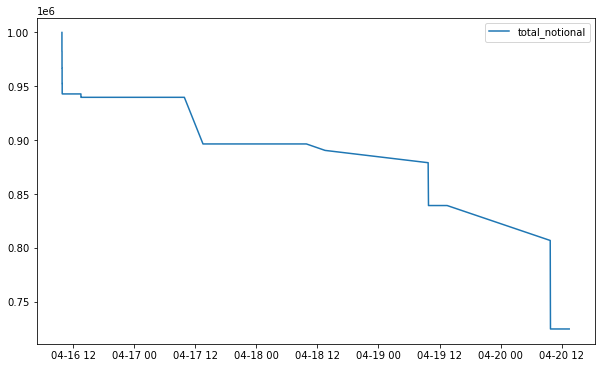

In [77]:
# plot cash and holding_notional and total_notional in one graph
plt.figure(figsize=(10, 6))
# plt.plot(bt.balance['timestamp'], bt.balance['cash'], label='cash')
# plt.plot(bt.balance['timestamp'], bt.balance['holding_notional'], label='holding_notional')
plt.plot(bt.balance['timestamp'], bt.balance['total_notional'], label='total_notional')
plt.legend()
plt.show()


In [108]:
class Backtest:
    def __init__(self, asset_info, start_time, end_time, unit, buy_cost, sell_cost, extra_cost):
        self.asset_info = asset_info
        self.start_time = start_time
        self.end_time = end_time
        self.date_range = pd.date_range(start=start_time, end=end_time, freq='1s')

        self.unit = unit
        self.buy_cost = buy_cost
        self.sell_cost = sell_cost
        self.extra_cost = extra_cost

        self.cash = 0
        self.coin_dydx = 0
        self.coin_apollox = 0
        self.portfolio = pd.DataFrame(columns=['timestamp', 'cash', 'coin_dydx', 'coin_apollox', 'total_value'])

    def buy(self, time, exchange, value): # value divided by asset_info ask price, (assume taking the best ask price), exchange = dydx or apollox, value = self.unit
        coin_amount = value / float(self.asset_info[f'{exchange}_ask'][asset_info_df['timestamp'] == time])
        self.cash = self.cash - self.buy_cost*abs(value) - abs(value)
        if exchange == 'dydx':
            self.coin_dydx = self.coin_dydx + coin_amount
        elif exchange == 'apollox':
            self.coin_apollox = self.coin_apollox + coin_amount
        else:
            pass

    def sell(self, time, exchange, value): # value divided by asset_info bid price, exchange = dydx or apollox, value = self.unit
        coin_amount = value / float(self.asset_info[f'{exchange}_bid'][asset_info_df['timestamp'] == time])
        self.cash = self.cash - self.sell_cost*abs(value) + abs(value) 
        if exchange == 'dydx':
            self.coin_dydx = self.coin_dydx - abs(coin_amount)
        elif exchange == 'apollox':
            self.coin_apollox = self.coin_apollox - abs(coin_amount)
        else:
            pass

    #Trade execution function
    def execute_trade(self, row):
        for exchange in ['dydx', 'apollox']:
            if int(row[f'{exchange}_signal']) == 1:
                self.buy(time=row['timestamp'].values[0], exchange=exchange, value=self.unit)
            elif int(row[f'{exchange}_signal']) == -1:
                self.sell(time=row['timestamp'].values[0], exchange=exchange, value=self.unit)
            else:
                pass
    
    def funding_payment(self, time, exchange, position):
        for exchange in ['dydx', 'apollox']:
            # funding calculation (need further modification)
            payment = float(self.asset_info[f'{exchange}_funding'][asset_info_df['timestamp'] == time]) * position *self.asset_info[f'exchange_bid'][self.asset_info['timestamp']==time].values[0]
            self.cash = self.cash + payment

    #Main function
    def run_backtesting(self):
        for timepoint in self.date_range:
            order_book = self.asset_info[self.asset_info['timestamp']==timepoint]

            # basic trade execution
            try:
                self.execute_trade(row=order_book)
                Total_value = self.cash + self.coin_dydx*self.asset_info['dydx_bid'][self.asset_info['timestamp']==timepoint].values[0] + self.coin_apollox*self.asset_info['apollox_bid'][self.asset_info['timestamp']==timepoint].values[0]

                self.portfolio = self.portfolio.append({'timestamp': timepoint, 
                                                    'cash': self.cash, 
                                                    'coin_dydx': self.coin_dydx, 
                                                    'coin_apollox': self.coin_apollox, 
                                                    'total_value': Total_value}, ignore_index=True)
            except:
                print('Data not available for ' + str(timepoint))

            # if timepoint is 00:00:00, 08:00:00, 16:00:00, then call funding payment
            if timepoint.hour % 8 == 0:
                self.funding_payment(time=timepoint, exchange='dydx', position=self.coin_dydx)
                self.funding_payment(time=timepoint, exchange='apollox', position=self.coin_apollox)